### Visual Attention Mechanism


Reference:
[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

`Some parts of the code were modified and comment lines were added.`

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
physical_devices = tf.config.experimental.list_physical_devices('GPU')

try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[0:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  print(physical_devices)
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")
  pass
'''

'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\n\ntry:\n  # Disable first GPU\n  tf.config.set_visible_devices(physical_devices[0:], \'GPU\')\n  logical_devices = tf.config.list_logical_devices(\'GPU\')\n  print(physical_devices)\n  # Logical device was not created for first GPU\n  assert len(logical_devices) == len(physical_devices) - 1\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  print("Invalid device or cannot modify virtual devices once initialized.")\n  pass\n'

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/yoshua_paper_results.png)

Reference: [Neural Machine Translation by Jointly Learning to Align and Translate
](https://arxiv.org/abs/1409.0473)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/attention_examples.png)

Reference:
[Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/se_example_2.png)

Reference:
[Squeeze-and-Excitation Networks](https://arxiv.org/abs/1709.01507)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_1.png)

![](https://raw.githubusercontent.com/EscVM/EscVM_YT/fd7f3f0798d40c3097690133778df82b26a0d96d/Notebooks/0%20-%20TF2.X%20Tutorials/media/tf_tutorial_2/cbam_example_2.png)

Reference:
[CBAM: Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)

In [3]:
experiment = {
    'IMAGE_SIZE': (32, 32),
    'INPUT_SHAPE': (32, 32, 3),

    'ACCELERATOR': 'GPU',  # Or 'TPU'

    'BATCH_SIZE': 32,
    'EPOCHS': 20,
    'AUTOTUNE': tf.data.experimental.AUTOTUNE,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0001,  # 1e-4

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_visual_attention_mechanism/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_visual_attention_mechanism/images",
}

In [4]:
from tensorflow.keras.layers import Layer, Dense, GlobalAveragePooling2D, Reshape
from tensorflow.keras.layers import GlobalMaxPooling2D, Add, Activation, MaxPooling2D
from tensorflow.keras.layers import Multiply, Conv2D, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.models import Sequential

class ChannelAttention(Layer):
  # Reference: https://arxiv.org/abs/1807.06521
  def __init__(self, filters, ratio):
    super(ChannelAttention, self).__init__()
    self.filters = filters
    self.ratio = ratio

  def build(self, input_shape):
    self.shared_layer_one = Dense(self.filters // self.ratio, activation='relu',
                                  kernel_initializer='he_normal', use_bias=True,
                                  bias_initializer='zeros')
    self.shared_layer_two = Dense(self.filters, kernel_initializer='he_normal',
                                  use_bias=True, bias_initializer='zeros')

  def call(self, inputs):
    avg_pool = GlobalAveragePooling2D()(inputs)

    avg_pool = self.shared_layer_one(avg_pool)
    avg_pool = self.shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Reshape((1,1,self.filters))(max_pool)

    max_pool = self.shared_layer_one(max_pool)
    max_pool = self.shared_layer_two(max_pool)

    attention = Add()([avg_pool, max_pool])
    attention = Activation('sigmoid')(attention)
    # tf.keras.layers.Multiply: It takes a list of tensors as input and computes
    # the element-wise product of those tensors, assuming they have the same shape.
    return Multiply()([inputs, attention])


In [5]:
class SpatialAttention(Layer):
  # Reference: https://arxiv.org/abs/1807.06521
  def __init__(self, kernel_size):
    super(SpatialAttention, self).__init__()
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.conv2d = Conv2D(filters=1, kernel_size=self.kernel_size, strides=1,
                         padding='same', activation='sigmoid',
                         kernel_initializer='he_normal', use_bias=False)

  def call(self, inputs):
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

    # tf.keras.layers.Concatenate: takes a list of tensors as input and concatenates
    # them along the specified axis to produce a single tensor.
    attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = self.conv2d(attention)

    return tf.keras.layers.multiply([inputs, attention])

### Build a Model

In [6]:
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                      shuffle_files=True, as_supervised=True,
                                      with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete5DDQ3E/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete5DDQ3E/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpel_cznzitfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

In [8]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
def visualize_images(image_batch):
  index = 0
  for image, label in image_batch.take(10):
    plt.subplot(2, 5, index + 1)
    index += 1
    plt.imshow(image[:])
    plt.axis('off')
  plt.tight_layout()
  plt.show()

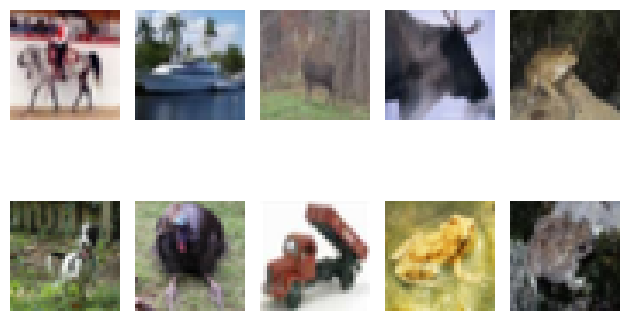

In [11]:
visualize_images(ds_train)

In [12]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

### Prepare Dataset

In [13]:
ds_train = ds_train.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

In [14]:
ds_test = ds_test.map(normalize, num_parallel_calls=experiment['AUTOTUNE'])
ds_test = ds_test.cache().batch(experiment['BATCH_SIZE']).prefetch(experiment['AUTOTUNE'])

### Build a Network without Attention

In [ ]:
def get_cnn_model_without_attention(verbose=0):
    model = Sequential([
        Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
        BatchNormalization(),
        Conv2D(32, 3, padding='same', activation='elu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, padding='same', activation='elu'),
        BatchNormalization(),
        Conv2D(64, 3, padding='same', activation='elu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, 3, padding='same', activation='elu'),
        BatchNormalization(),
        Conv2D(128, 3, padding='same', activation='elu'),
        GlobalAveragePooling2D(),
        Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])
    if verbose > 0:  model.summary()
    return model

In [ ]:
simple_cnn_no_attention = get_cnn_model_without_attention(verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [ ]:
model_hist = simple_cnn_no_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 34s 9ms/step - loss: 1.1841 - accuracy: 0.5761
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7746 - accuracy: 0.7294
Epoch 3/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6182 - accuracy: 0.7853
Epoch 4/20
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5124 - accuracy: 0.8233
Epoch 5/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.4307 - accuracy: 0.8503
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3588 - accuracy: 0.8748
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2978 - accuracy: 0.8939
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2431 - accuracy: 0.9142
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2002 - accuracy: 0.9300
Epoch 10/20
1563/1563 [==============================] - 11s 7ms/step - l

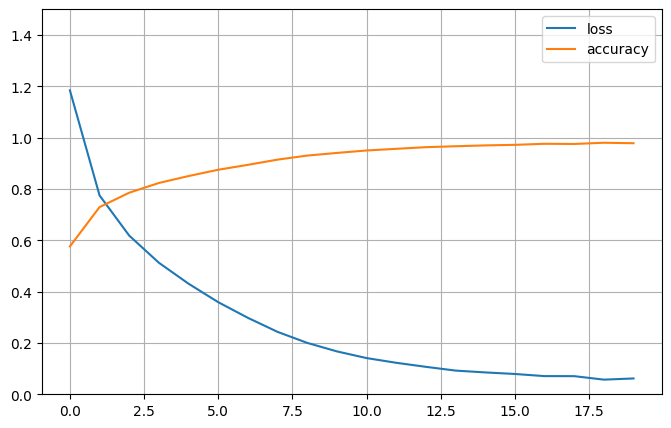

In [ ]:
import pandas as pd

pd.DataFrame(model_hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [ ]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 3s 8ms/step - loss: 0.9053 - accuracy: 0.8113
Test accuracy: 0.8112999796867371


### Build a Network with Attention

In [15]:
def get_cnn_model_with_attention(verbose=0):
    model = Sequential([
    Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    BatchNormalization(),
    Conv2D(32, 3, padding='same', activation='elu'),
    BatchNormalization(),

    ChannelAttention(32, 8),
    SpatialAttention(7),

    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, 3, padding='same', activation='elu'),
    BatchNormalization(),
    Conv2D(64, 3, padding='same', activation='elu'),
    BatchNormalization(),

    ChannelAttention(64, 8),
    SpatialAttention(7),

    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, 3, padding='same', activation='elu'),
    BatchNormalization(),
    Conv2D(128, 3, padding='same', activation='elu'),

    ChannelAttention(128, 8),
    SpatialAttention(7),

    GlobalAveragePooling2D(),
    Dense(ds_info.features['label'].num_classes, activation='softmax' )
    ])
    if verbose > 0:  model.summary()

    return model

In [16]:
simple_cnn_with_attention = get_cnn_model_with_attention(verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 channel_attention (Channel  (None, 32, 32, 32)        292       
 Attention)                                                      
                                                        

In [17]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [18]:
history = simple_cnn_with_attention.fit(ds_train, epochs=experiment['EPOCHS'])

Epoch 1/20
1563/1563 [==============================] - 47s 14ms/step - loss: 1.3226 - accuracy: 0.5234
Epoch 2/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9523 - accuracy: 0.6607
Epoch 3/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7744 - accuracy: 0.7287
Epoch 4/20
1563/1563 [==============================] - 21s 14ms/step - loss: 0.6537 - accuracy: 0.7733
Epoch 5/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5685 - accuracy: 0.8016
Epoch 6/20
1563/1563 [==============================] - 23s 14ms/step - loss: 0.4981 - accuracy: 0.8258
Epoch 7/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.4371 - accuracy: 0.8460
Epoch 8/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.3842 - accuracy: 0.8642
Epoch 9/20
1563/1563 [==============================] - 22s 14ms/step - loss: 0.3339 - accuracy: 0.8831
Epoch 10/20
1563/1563 [==============================] - 21s 14m

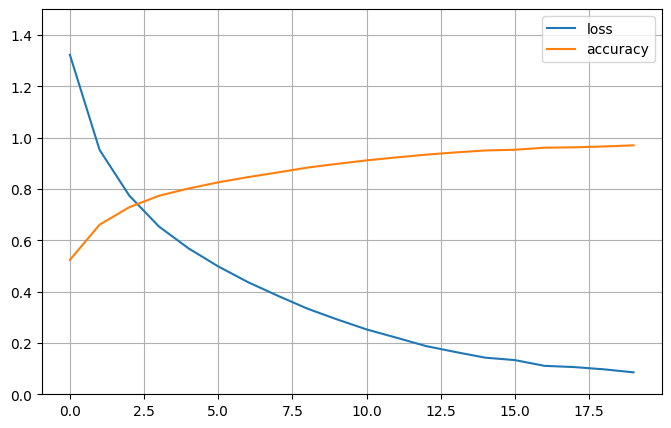

In [19]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [20]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 4s 10ms/step - loss: 0.8815 - accuracy: 0.8067
Test accuracy: 0.8066999912261963


### Visualize Attention network

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Prediction index is the index that has the maximum prediction value
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (32, 32, 32, 3)
y_test.shape: (32,)


In [23]:
import math
import warnings
import numpy as np

def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
            ))
            # math.ceil: Round a number upward to its nearest integer
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate([
            np.concatenate(array[index * num_columns : (index + 1) * num_columns], axis=1)
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid

In [24]:
def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")

In [25]:
import numpy as np
import cv2

def heatmap_display(
    heatmap, original_image, colormap=cv2.COLORMAP_VIRIDIS, image_weight=0.7):
    """
    Apply a heatmap (numpy.ndarray) on top of an original image.

    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply the heatmap
        colormap (int): OpenCV Colormap to use for heatmap visualization
        image_weight (float): An optional `float` value in range [0,1] indicating the weight of
            the input image to be overlaying the calculated attribution maps. Defaults to `0.7`

    Returns:
        numpy.ndarray: Original image with heatmap applied
    """
    image = image_to_uint_255(original_image)

    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    if (heatmap.max() - heatmap.min()) != 0:
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )

    output = cv2.addWeighted(
        cv2.cvtColor(image, cv2.COLOR_RGB2BGR),
        image_weight,
        heatmap,
        1 - image_weight,
        0,
    )

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [26]:
from pathlib import Path
import cv2

def save_rgb(image, output_dir, output_name):
    """
    Save a 3D Numpy array (H, W, 3) as an image.

    Args:
        image (numpy.ndarray): Image to save
        output_dir (str): Output directory
        output_name (str): Output name
    """
    Path.mkdir(Path(output_dir), parents=True, exist_ok=True)

    cv2.imwrite(
        str(Path(output_dir) / output_name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    )

### Network without vs with Attention

In [27]:
import numpy as np
import tensorflow as tf
import cv2
import math
import warnings

class GradCAM:
    """
    Perform Grad CAM algorithm for a given input
    Paper: [Grad-CAM: Visual Explanations from Deep Networks
            via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
    """
    def explain(
        self,
        validation_data,
        model,
        class_index,
        layer_name=None,
        use_guided_grads=True,
        colormap=cv2.COLORMAP_VIRIDIS,
        image_weight=0.7,
    ):
        """
        Compute GradCAM for a specific class index.

        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            layer_name (str): Targeted layer for GradCAM. If no layer is provided, it is
                automatically infered from the model architecture.
            colormap (int): OpenCV Colormap to use for heatmap visualization
            image_weight (float): An optional `float` value in range [0,1] indicating the weight of
                the input image to be overlaying the calculated attribution maps. Defaults to `0.7`.
            use_guided_grads (boolean): Whether to use guided grads or raw gradients

        Returns:
            numpy.ndarray: Grid of all the GradCAM
        """
        images, _ = validation_data

        if layer_name is None:
            layer_name = self.infer_grad_cam_target_layer(model)

        outputs, grads = GradCAM.get_gradients_and_filters(
            model, images, layer_name, class_index, use_guided_grads
        )

        cams = GradCAM.generate_ponderated_output(outputs, grads)

        heatmaps = np.array(
            [
                # not showing the actual image if image_weight=0
                heatmap_display(cam.numpy(), image, colormap, image_weight)
                for cam, image in zip(cams, images)
            ]
        )

        grid = grid_display(heatmaps)

        return grid

    @staticmethod
    def infer_grad_cam_target_layer(model):
        """
        Search for the last convolutional layer to perform Grad CAM, as stated
        in the original paper.

        Args:
            model (tf.keras.Model): tf.keras model to inspect

        Returns:
            str: Name of the target layer
        """
        for layer in reversed(model.layers):
            # Select closest 4D layer to the end of the network.
            if len(layer.output_shape) == 4:
                return layer.name

        raise ValueError(
            "Model does not seem to contain 4D layer. Grad CAM cannot be applied."
        )

    @staticmethod
    def get_gradients_and_filters(model, images, layer_name, class_index, use_guided_grads):
        """
        Generate guided gradients and convolutional outputs with an inference.

        Args:
            model (tf.keras.Model): tf.keras model to inspect
            images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
            use_guided_grads (boolean): Whether to use guided grads or raw gradients

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
        """
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_outputs)

        if use_guided_grads:
            grads = (
                tf.cast(conv_outputs > 0, "float32")
                * tf.cast(grads > 0, "float32")
                * grads
            )

        return conv_outputs, grads

    @staticmethod
    def generate_ponderated_output(outputs, grads):
        """
        Apply Grad CAM algorithm scheme.

        Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
        From there:
            - we compute the spatial average of the gradients
            - we build a ponderated sum of the convolutional outputs based on those averaged weights

        Args:
            output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)

        Returns:
            List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
        """

        maps = [
            GradCAM.ponderate_output(output, grad)
            for output, grad in zip(outputs, grads)
        ]

        return maps

    @staticmethod
    def ponderate_output(output, grad):
        """
        Perform the ponderation of filters output with respect to average of gradients values.

        Args:
            output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)

        Returns:
            tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
        """
        weights = tf.reduce_mean(grad, axis=(0, 1))

        # Perform ponderated sum : w_i * output[:, :, i]
        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

        return cam

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.

        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_rgb(grid, output_dir, output_name)

In [28]:
def explainGradCam(explainer, ax, img, y, model_1, y_pred_1, model_2, y_pred_2, class_names):
    """
    Plot GRADCAM of two trained models. It needs an axes with two columns
    """
    data = ([img], None)

    y_predm_1 = np.argmax(y_pred_1)
    y_predm_2 = np.argmax(y_pred_2)

    grid_1 = explainer.explain(
        data, model_1, class_index=y_predm_1, image_weight=0.8)
    grid_2 = explainer.explain(
        data, model_2, class_index=y_predm_2, image_weight=0.8)

    ax[0].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_1],
                                                     100*np.max(y_pred_1),
                                                     class_names[y]),
                     color=('blue' if y == y_predm_1 else 'red'))

    ax[1].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_2],
                                                     100*np.max(y_pred_2),
                                                     class_names[y]),
                     color=('blue' if y == y_predm_2 else 'red'))
    ax[0].imshow(grid_1)
    ax[1].imshow(grid_2)

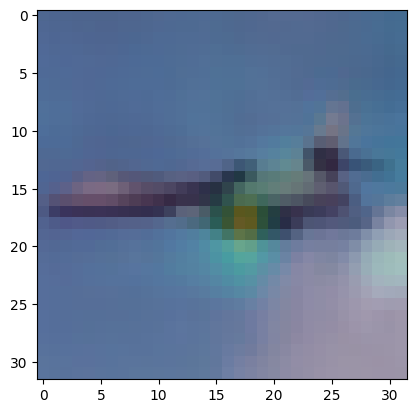

In [69]:
gradCam = GradCAM()

for img, label in zip(X_test, y_test):
    data = ([img], None)
    output = gradCam.explain(data,
            simple_cnn_with_attention,
            class_index=3,
            layer_name=None,
            use_guided_grads=True)
    plt.imshow(output)

1/1 [==============================] - 0s 34ms/step


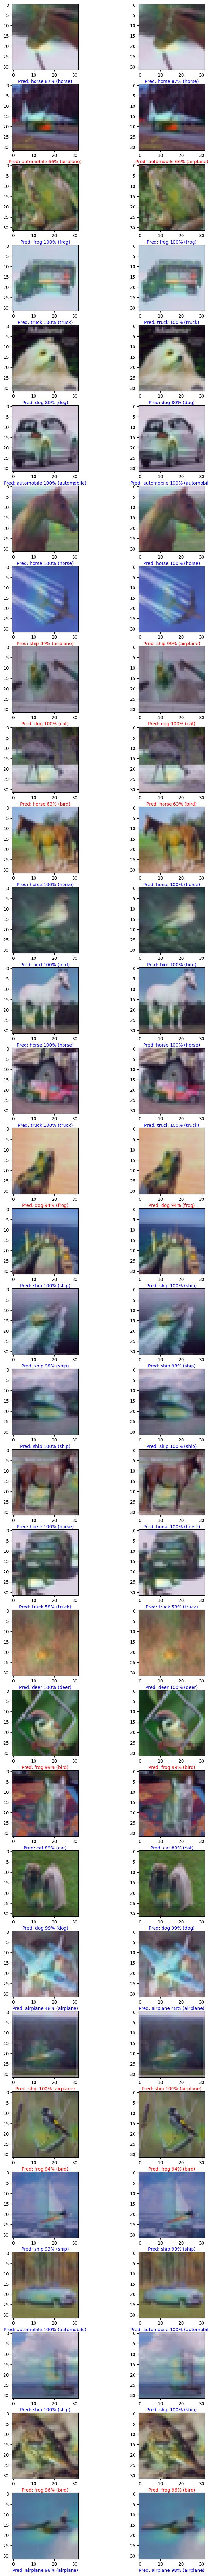

In [65]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(gradCam, axes[index], img,
               label,
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]),
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1

In [31]:
'''
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]),
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1
'''

"\nfig, axes = plt.subplots(32, 2, figsize=(8,80))\nfig.tight_layout()\nindex = 0\nfor img, label in zip(X_test, y_test):\n    explainGradCam(explainer, axes[index], img,\n               label,\n               simple_cnn_no_attention,\n               simple_cnn_no_attention.predict(img[None]),\n               simple_cnn_with_attention,\n               simple_cnn_with_attention.predict(img[None]),\n               class_names=ds_info.features['label'].names)\n    index += 1\n"

### Reference

[EscVM_YT/Notebooks/0 - TF2.X Tutorials
/tf_2_visual_attention.ipynb](https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb)

https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/display.py

https://github.com/sicara/tf-explain/blob/master/tf_explain/utils/saver.py

https://www.youtube.com/watch?v=1mjI_Jm4W1E
